In [23]:
import pandas as pd
import numpy as np
import pyBigWig as pb
import matplotlib.pyplot as plt
import seaborn as sbn
import pybedtools
import os

Define matplotlib plotting paramters

In [24]:
matplotlib.rcParams.update({'font.size': 22})

Change Working directory to the directory where the files are

In [25]:
os.chdir("/groups/gerlich/members/MichaelMitter/PythonClub/Sequencing_data_lesson_1/Data")

In [26]:
os.listdir()

['SMC3_chip_seq.bed',
 'SMC3_chip_seq.bw',
 'CTCF_chip_seq.bed',
 'XRCC4_chip-seq.bw',
 'RAD51_chip-seq.bw']

Load in smc3 chip-seq data

In [27]:
smc3 = pybedtools.BedTool("SMC3_chip_seq.bed").to_dataframe()
smc3

,chrom,start,end,name,score,strand
0,chr1,237576,238056,1:HeLa_SMC3_G2_2:.:237576-238056,1,.
1,chr1,804829,805584,2:HeLa_SMC3_G2_3:.:804829-805584,1,.
2,chr1,853728,856860,2:HeLa_SMC3_G2_4:.:853728-856860,1,.
3,chr1,873229,874267,1:HeLa_SMC3_G2_5:.:873232-874187|2:HeLa_SMC3_G...,2,.
4,chr1,886670,887175,1:HeLa_SMC3_G2_6:.:886670-887175,1,.
...,...,...,...,...,...,...
37119,chrX,154365622,154366423,2:HeLa_SMC3_G2_46358:.:154365622-154366423,1,.
37120,chrX,154376943,154378034,1:HeLa_SMC3_G2_49045:.:154376943-154377936|2:H...,2,.
37121,chrX,154891956,154892601,1:HeLa_SMC3_G2_49048:.:154891956-154892601,1,.
37122,chrX,155049035,155050437,1:HeLa_SMC3_G2_49049:.:155049062-155050437|2:H...,2,.


- One could also use pd.read_csv(), but then we need to take care of csv separating characters by hand

Now we calculate the midpoint of each peak to have a single location where we can do pileups

In [28]:
smc3.loc[:, "mid"] = (smc3["start"] + smc3["end"])//2
smc3

,chrom,start,end,name,score,strand,mid
0,chr1,237576,238056,1:HeLa_SMC3_G2_2:.:237576-238056,1,.,237816
1,chr1,804829,805584,2:HeLa_SMC3_G2_3:.:804829-805584,1,.,805206
2,chr1,853728,856860,2:HeLa_SMC3_G2_4:.:853728-856860,1,.,855294
3,chr1,873229,874267,1:HeLa_SMC3_G2_5:.:873232-874187|2:HeLa_SMC3_G...,2,.,873748
4,chr1,886670,887175,1:HeLa_SMC3_G2_6:.:886670-887175,1,.,886922
...,...,...,...,...,...,...,...
37119,chrX,154365622,154366423,2:HeLa_SMC3_G2_46358:.:154365622-154366423,1,.,154366022
37120,chrX,154376943,154378034,1:HeLa_SMC3_G2_49045:.:154376943-154377936|2:H...,2,.,154377488
37121,chrX,154891956,154892601,1:HeLa_SMC3_G2_49048:.:154891956-154892601,1,.,154892278
37122,chrX,155049035,155050437,1:HeLa_SMC3_G2_49049:.:155049062-155050437|2:H...,2,.,155049736


Now we open the pybigwig file and extract the profile of 500 peaks at a window of -1000 to 1000 bp

In [70]:
profiles = []
with pb.open("SMC3_chip_seq.bw") as bw:
    for index, row in enumerate(smc3.iterrows()):
        if index > 2000:
            break
        chrom = row[1]["chrom"]
        position = row[1]["mid"]
        singleProfile = bw.values(chrom, position - 1000, position + 1000)
        xValues = np.arange(2000) - 1000
        tempFrame = pd.DataFrame({"ID": row[0],"Position": xValues ,"values": singleProfile})
        profiles.append(tempFrame)
profileFrame = pd.concat(profiles, axis=0)
profileFrame

,ID,Position,values
0,0,-1000,0.095436
1,0,-999,0.095436
2,0,-998,0.095436
3,0,-997,0.095436
4,0,-996,0.095436
...,...,...,...
1995,2000,995,0.000000
1996,2000,996,0.000000
1997,2000,997,0.000000
1998,2000,998,0.000000


Now we use groupby to calculate average values

In [71]:
averageProfile = profileFrame.groupby(["Position"]).agg({"values": np.mean}).reset_index("Position")
averageProfile

,Position,values
0,-1000,0.059856
1,-999,0.059999
2,-998,0.059904
3,-997,0.060857
4,-996,0.061001
...,...,...
1995,995,0.063910
1996,996,0.063910
1997,997,0.063958
1998,998,0.063958


Now we plot the profile

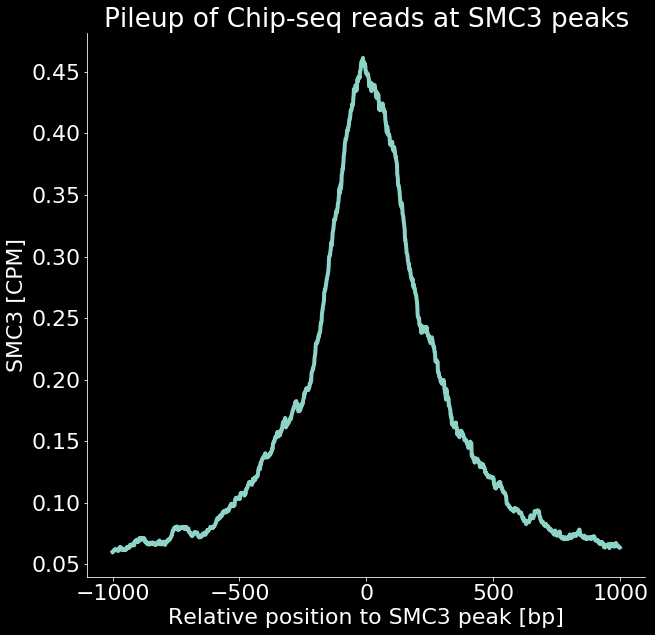

In [72]:
f, ax = plt.subplots()
ax.plot(averageProfile["Position"], averageProfile["values"], lw=4)
f.set_size_inches(10, 10)
sbn.despine()
ax.set(xlabel="Relative position to SMC3 peak [bp]", ylabel="SMC3 [CPM]", title="Pileup of Chip-seq reads at SMC3 peaks")
plt.show()

Next we plot heatmaps of this data

In [73]:
heatmap = pd.pivot_table(profileFrame, index="ID", columns=["Position"], values="values")
heatmap

Position,-1000,-999,-998,-997,-996,-995,-994,-993,-992,-991,...,990,991,992,993,994,995,996,997,998,999
ID,,,,,,,,,,,,,,,,,,,,,
0,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,...,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436
4,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436
1998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


- We need pivot_table here to convert the data in the "tidy" format to a dense format

Now we sort the rows based on the center value

In [74]:
heatmap.loc[:, "SMC3_center"] = heatmap.apply(lambda x: np.nanmean(x[900:1100]), axis=1)
heatmapSorted = heatmap.sort_values(by="SMC3_center", ascending=False).drop(columns="SMC3_center")
heatmapSorted

Position,-1000,-999,-998,-997,-996,-995,-994,-993,-992,-991,...,990,991,992,993,994,995,996,997,998,999
ID,,,,,,,,,,,,,,,,,,,,,
0,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,...,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436
51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1948,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,0.095436,...,1.145230,1.145230,1.145230,1.145230,1.145230,1.145230,1.145230,1.145230,1.145230,1.145230
1958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
479,1.336100,1.336100,1.336100,1.336100,1.336100,1.336100,1.336100,1.336100,1.336100,1.336100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.477178,0.477178,0.477178,0.477178,0.477178,0.477178,0.477178,0.477178,0.477178,0.477178
1179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Then, we create a heatmap plot

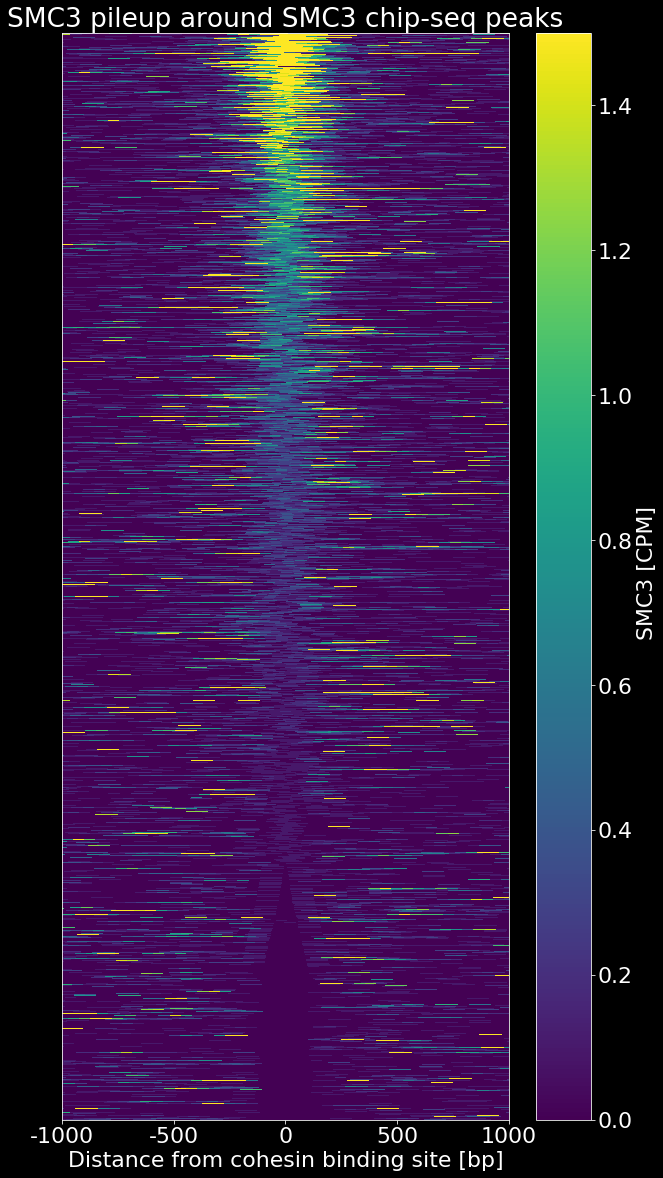

In [124]:
f, ax = plt.subplots()
image = ax.imshow(heatmapSorted.values, vmin=0, vmax=1.5, aspect="auto", interpolation="nearest")
ax.set(xlabel="Distance from cohesin binding site [bp]", ylabel="")
locs, labels = plt.xticks()
plt.xticks(locs[1:], np.arange(-1000,1500, 500))
cbar = f.colorbar(image)
cbar.set_label(label=" SMC3 [CPM]")
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_title("SMC3 pileup around SMC3 chip-seq peaks")
f.set_size_inches(10, 20)
plt.show()